
# Food Tags Analysis (OpenFoodFacts)

This notebook analyzes the **`ingredients_tags`** field from `openfoodfacts-rowcolcatvalencut.csv`:
- Cleans/splits tags (`','` and `'|'` supported)
- Drops language prefixes (e.g., `en:`)
- Shows a **Top-N bar plot**
- Builds a **Zipf-like scatter plot** (rank vs. frequency)
- Includes a quick dataframe preview of the most frequent tags


In [1]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Config ---
CSV_CANDIDATES = [
    "../data/openfoodfacts/openfoodfacts-rowcolcatvalencut.csv",
    "openfoodfacts-rowcolcatvalencut.csv"
]
COL = "ingredients_tags"   # OFF-style tag list, like "en:sugar,en:wheat-flour,..."
TOP = 100                   # show top N tags (set to None to show all)

# Resolve file path
CSV_PATH = None
for p in CSV_CANDIDATES:
    if os.path.isfile(p):
        CSV_PATH = p
        break
if CSV_PATH is None:
    raise FileNotFoundError("Could not find 'openfoodfacts-rowcolcatvalencut.csv' in expected locations.")
print("Using file:", CSV_PATH)


Using file: ../data/openfoodfacts/openfoodfacts-rowcolcatvalencut.csv


In [2]:

df = pd.read_csv(CSV_PATH, low_memory=False, dtype=str)
print(f"Loaded {len(df):,} rows and {len(df.columns)} columns.")
if COL not in df.columns:
    raise KeyError(f"Column '{COL}' not found. Available: {list(df.columns)}")
df.head(3)


Loaded 107,587 rows and 18 columns.


,created_datetime,product_name,food_groups,energy-kcal_100g,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,ingredients_tags,nutriscore_score,nutriscore_grade,created_t,energy-kj_100g,sodium_100g
0,2018-04-15T16:43:14Z,Madeleines ChocoLait,en:biscuits-and-cakes,460.0,1926.0,24.0,6.0,54.0,31.0,1.4,6.4,0.48,"en:wheat-flour,en:cereal,en:flour,en:wheat,en:...",20,e,1523810594,0.0,0.0
1,2018-09-19T14:22:43Z,Multi Patents Collagen Peptides,en:biscuits-and-cakes,350.0,1460.0,0.0,0.0,0.0,9.09,0.0,90.9,0.0,"en:hyaluronic-acid,en:superfoods-blend,en:mill...",-1,a,1537366963,0.0,0.0
2,2020-01-21T14:38:39Z,Abricots,en:dried-fruits,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"en:apricot,en:fruit",-4,a,1579617519,0.0,0.0


In [3]:

# Split, clean, normalize
tags = (
    df[COL]
      .dropna()
      .astype(str)
      .str.split(r"[|,]")           # handle '|' or ',' separators
      .explode()
      .str.strip()
      .replace("", np.nan)
      .dropna()
      .str.lower()
      .str.replace(r"^[a-z]{2}:", "", regex=True)  # drop 'en:' / 'fr:' prefixes etc.
)

counts = tags.value_counts()
top_counts = counts.head(int(TOP)) if TOP else counts
top_counts = top_counts.sort_values(ascending=True)
top_counts.head()


ingredients_tags
berries            11372
reduced-iron       11532
modified-starch    12171
fat                12189
vanilla            12197
Name: count, dtype: int64

## Top-N Tag Frequencies (Bar Plot)

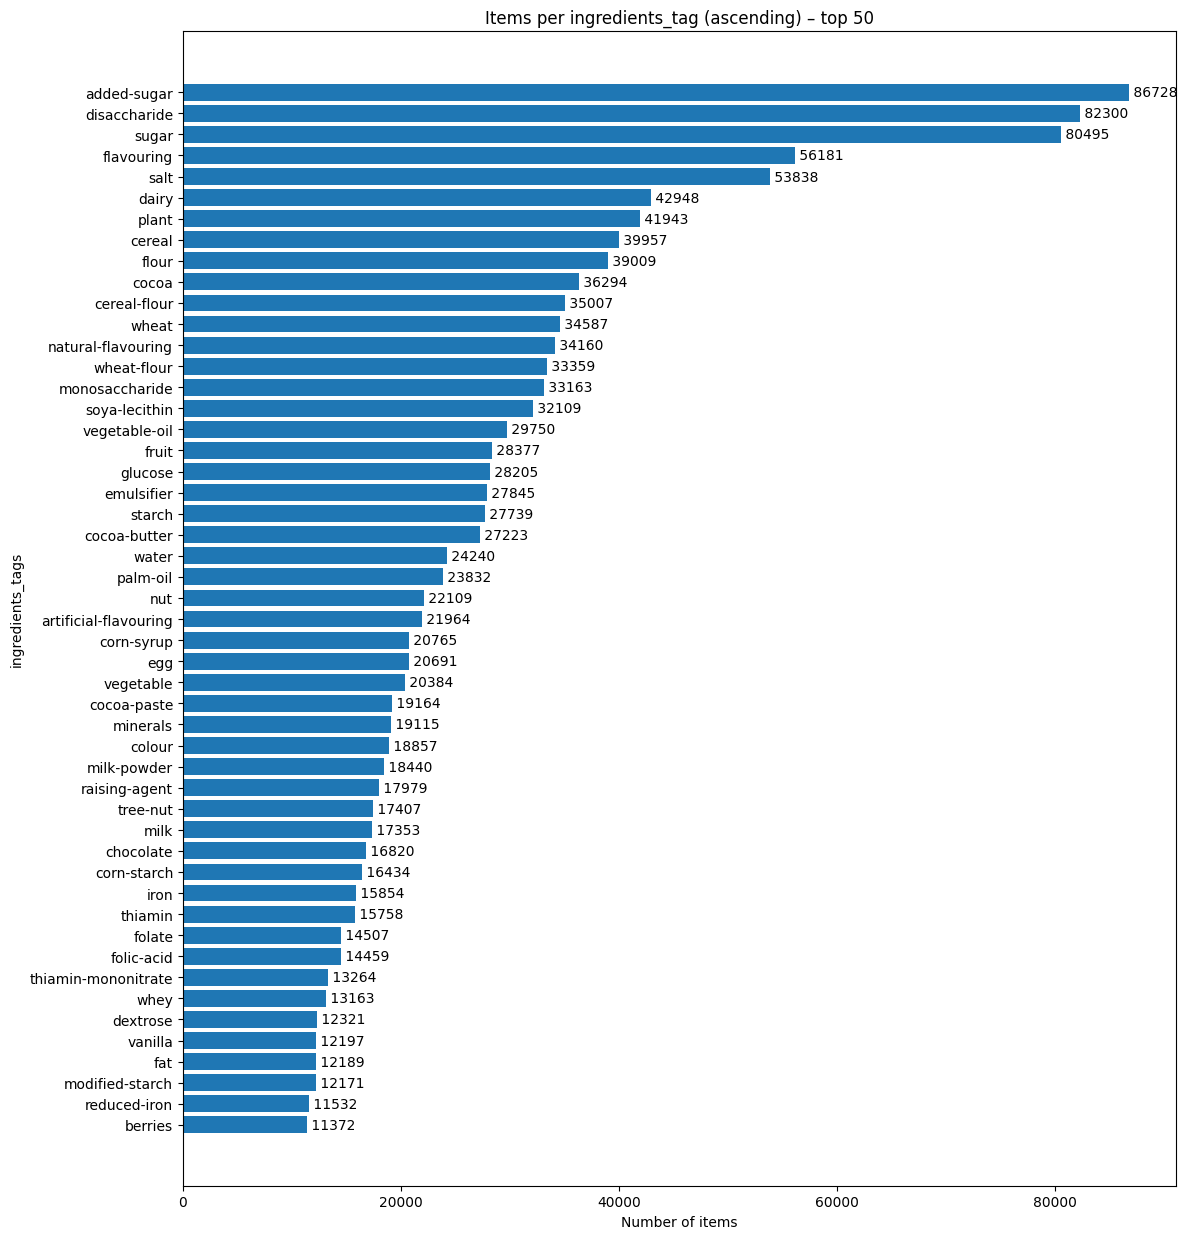

In [4]:

if top_counts.empty:
    print("No non-empty values in 'ingredients_tags' to plot.")
else:
    height = min(max(4, 0.25 * len(top_counts)), 18)
    plt.figure(figsize=(12, height))
    plt.barh(top_counts.index.astype(str), top_counts.values)
    plt.xlabel("Number of items")
    plt.ylabel("ingredients_tags")
    plt.title(f"Items per ingredients_tag (ascending){' – top '+str(TOP) if TOP else ''}")

    for y, v in enumerate(top_counts.values):
        plt.text(v, y, f" {v}", va="center")
    plt.tight_layout()
    plt.show()


## Rank–Frequency Scatter (Zipf-like)

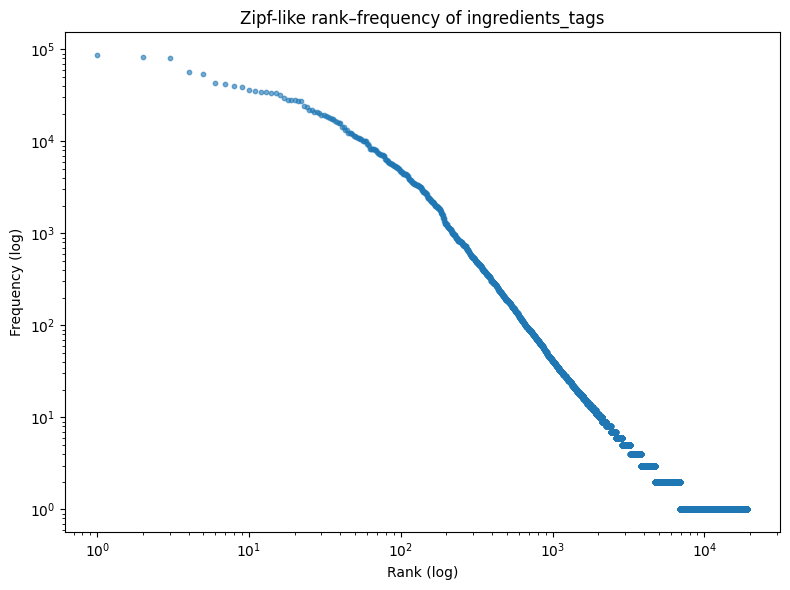

In [5]:

if counts.empty:
    print("No tags to scatter.")
else:
    freq = counts.values
    # Sort descending for rank curve
    freq_sorted = np.sort(freq)[::-1]
    rank_sorted = np.arange(1, len(freq_sorted)+1)

    plt.figure(figsize=(8,6))
    plt.scatter(rank_sorted, freq_sorted, s=10, alpha=0.6)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Rank (log)")
    plt.ylabel("Frequency (log)")
    plt.title("Zipf-like rank–frequency of ingredients_tags")
    plt.tight_layout()
    plt.show()


## Top Tags Table

In [6]:

top_table = counts.head(100).rename("count").reset_index().rename(columns={"index": "tag"})
top_table.head(20)


,ingredients_tags,count
0,added-sugar,86728
1,disaccharide,82300
2,sugar,80495
3,flavouring,56181
4,salt,53838
5,dairy,42948
6,plant,41943
7,cereal,39957
8,flour,39009
9,cocoa,36294


## Save Top Tags (optional)

In [7]:

out_csv = os.path.join(os.path.dirname(CSV_PATH) or ".", "openfoodfacts-top-tags.csv")
top_table.to_csv(out_csv, index=False)
print("Saved:", out_csv)


Saved: ../data/openfoodfacts\openfoodfacts-top-tags.csv
